# Проект. Создание рекомендательной системы для финансовых продуктов банка

***Заказчик***: **Caja de ahorros**

***Бизнес-задача***: Заказчик хочет стать банком-советником, доверенной площадкой, на которой клиенты получают весь спектр технологичных финансовых услуг. Банк будет выступать агрегатором платформ под собственным брендом, консолидируя разные потребности клиента на единой площадке. Для менеджмента банка важно принимать решения исходя из объективных данных, в том числе в области маркетинга. Основой для развития данной стратегии взаимодействия с клиентами будет являтся приведенное ниже исследование и разрабатываемая рекомнедательная система.

***Цель***: Выполнить исследование и подготовку данных, определить эффективные методы машинного обучения для создания персональных рекомендаций с целью повышения.

***Гипотеза***: Применение двустадийного подхода и использование дополнительных признаков позволит создавать наиболее релевантные персональные рекомендации.

***Ожидаемый результат***: набор скриптов в репозитории, выполнение которых позволит рассчитать персональные рекомендации, а затем запустить соответствующий сервис, который можно будет интегрировать в существующие инструменты взаимодействия с клиентами. 

## Подключение библиотек и модулей

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import pickle
import scipy
import sklearn.metrics
import sklearn.preprocessing
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
from tqdm import tqdm
from urllib.parse import urlencode
import zipfile
import os
import sys
import mlflow
import psycopg
from sqlalchemy import create_engine
import yaml
from dotenv import load_dotenv

## Работа с локальными переменными и подключение к БД

In [21]:
ASSETS = "assets"
FILE_NAME = './data/initial_data.csv.zip'
FILE_NAME_CSV = './data/train_ver2.csv'
DATA = "./data"

In [22]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
YOUR_NAME = "GEORGE_V_BUSLAEV" # введите своё имя для создания уникального эксперимента
assert YOUR_NAME, "введите своё имя в переменной YOUR_NAME для создания уникального эксперимента"
EXPERIMENT_NAME = f"bank_rexsys_by_{YOUR_NAME}"
REGISTRY_MODEL_NAME = "bank_recsys_model_george_buslaev"
RANDOM_STATE = 23

In [23]:
os.makedirs(ASSETS, exist_ok=True)
os.makedirs('./data', exist_ok=True)

In [24]:
s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

## Исследовательский Анализ Данных (EDA)

На этом этапе будет проведен исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных.

### Загрузка и предварительный обзор данных

In [25]:
def yandex_disk_download(public_key, file_name):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    urlencode(dict(public_key=public_key))
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open(file_name, 'wb') as f:
        f.write(download_response.content)

In [26]:
def extract_zip(zip_filepath, extract_to_dir):
    """Извлекает zip-файл в указанный каталог.
    Args:
    zip_filepath: Путь к .zip-файлу;
    extract_to_dir: Каталог для извлечения файлов. Будет создан, если он не существует.
    """
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_to_dir)
        print(f"Файлы успешно распаковыаны в: {extract_to_dir}")
    except FileNotFoundError:
        print(f"Ошибка: Zip-файл не найден по адресу: {zip_filepath}")
    except zipfile.BadZipFile:
        print(f"Ошибка: Неверный или поврежденный zip-файл: {zip_filepath}")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка: {e}")

In [27]:
if not os.path.exists(FILE_NAME):
    print(f"Идет загрузка данных")
    yandex_disk_download('https://disk.yandex.com/d/Io0siOESo2RAaA', FILE_NAME)
    print(f"Загрузка данных закончена, идет распаковка")
    extract_zip(FILE_NAME, DATA)   
else:
    print(f"Данные уже загружены")

Идет загрузка данных
Загрузка данных закончена, идет распаковка
Файлы успешно распаковыаны в: ./data


In [28]:
df = pd.read_csv('./data/train_ver2.csv',
                  parse_dates = ['fecha_dato',
                                 'fecha_alta',
                                 'ult_fec_cli_1t'],
                  low_memory=False,
                  keep_default_na=False
                 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   fecha_dato             datetime64[ns]
 1   ncodpers               int64         
 2   ind_empleado           object        
 3   pais_residencia        object        
 4   sexo                   object        
 5   age                    object        
 6   fecha_alta             datetime64[ns]
 7   ind_nuevo              object        
 8   antiguedad             object        
 9   indrel                 object        
 10  ult_fec_cli_1t         datetime64[ns]
 11  indrel_1mes            object        
 12  tiprel_1mes            object        
 13  indresi                object        
 14  indext                 object        
 15  conyuemp               object        
 16  canal_entrada          object        
 17  indfall                object        
 18  tipodom             

In [29]:
df['fecha_dato'].unique()

<DatetimeArray>
['2015-01-28 00:00:00', '2015-02-28 00:00:00', '2015-03-28 00:00:00',
 '2015-04-28 00:00:00', '2015-05-28 00:00:00', '2015-06-28 00:00:00',
 '2015-07-28 00:00:00', '2015-08-28 00:00:00', '2015-09-28 00:00:00',
 '2015-10-28 00:00:00', '2015-11-28 00:00:00', '2015-12-28 00:00:00',
 '2016-01-28 00:00:00', '2016-02-28 00:00:00', '2016-03-28 00:00:00',
 '2016-04-28 00:00:00', '2016-05-28 00:00:00']
Length: 17, dtype: datetime64[ns]

Данные начинаются с 28 января 2015 года и содержат ежемесячные записи о продуктах, которые имеет клиент, например, «кредитная карта», «сберегательный счет» и т. д. Необходимо предсказать, какие дополнительные продукты клиент получит в месяце 2016 года. 

### Предварительный обзор данных

В таблице присутсвуют данные по следующим признакам:

- *fecha_dato* — Исследуемые даты по месяцам,

- *ncodpers* — Идентификатор пользователя,

- *ind_empleado* — Статус занятости:
                    - A — трудоустроен
                    - B — безработный, раньше работал
                    - F — иждивенец
                    - N — безработный
                    - P — пассивный (статус не определён),

- *pais_residencia* — Страна резидентства,

- *sexo* — Пол,

- *age* — Возраст,

- *fecha_alta* — Дата, когда клиент впервые заключил договор в банке,

- *ind_nuevo* — 1, если клиент зарегистрировался за последние 6 месяце,

- *antiguedad* — Стаж клиента (в месяцах),

- *indrel* — 1 если первичный клиент, 99 — первичный клиент в течении месяца, но не в конце,

- *ult_fec_cli_1t* — Последняя дата, когда клиент был премиальным,

- *indrel_1mes* — Тип клиента в начале месяца:
                    - 1 — премиальный
                    - 2 — собственник
                    - P — потенциальный
                    - 3 — раньше был премиальным
                    - 4 — раньше был собственником.

- *tiprel_1mes* — Тип клиента в начале месяца:
                    - A — активный
                    - I — неактивный
                    - P — бывший
                    - R — потенциальный.

- *indresi* — Если страна проживания совпадает со страной банка,

- *indext* — Если страна рождения клиента отличается от страны банка,

- *conyuemp* — 1, если клиент супруг(а) работника,

- *canal_entrada* — Канал, по которому пришел пользователь,

- *indfall* — Индекс актуальности счёта (англ. Deceased index, N/S),

- *tipodom* — Тип адреса (1 — основной адрес),

- *cod_prov* — Код провинции (адреса клиента),

- *nomprov* — Имя провинции,

- *ind_actividad_cliente* — Активность пользователя (1 — активный, 0 — неактивный),

- *renta* — Доход домохозяйства,

- *segmento* — Сегментация: 1 — VIP, 2 — Обыкновенные 3 — выпускники колледжей.
---

И целевые признаки обозначаются:
- ***ind_ahor_fin_ult1*** **— Сберегательный счёт,**
- ***ind_aval_fin_ult1*** **— Банковская гарантия,**
- ***ind_cco_fin_ult1*** **— Текущие счета,**
- ***ind_cder_fin_ult1*** **— Деривативный счёт,**
- ***ind_cno_fin_ult1*** **— Зарплатный проект,**
- ***ind_ctju_fin_ult1*** **— Детский счёт,**
- ***ind_ctma_fin_ult1*** **— Особый счёт 3,**
- ***ind_ctop_fin_ult1*** **— Особый счёт,**
- ***ind_ctpp_fin_ult1*** **— Особый счёт 2,**
- ***ind_deco_fin_ult1*** **— Краткосрочный депозит,**
- ***ind_deme_fin_ult1*** **— Среднесрочный депозит,**
- ***ind_dela_fin_ult1*** **— Долгосрочный депозит,**
- ***ind_ecue_fin_ult1*** **— Цифровой счёт,**
- ***ind_fond_fin_ult1*** **— Денежный средства,**
- ***ind_hip_fin_ult1*** **— Ипотека,**
- ***ind_plan_fin_ult1*** **— Пенсионный план,**
- ***ind_pres_fin_ult1*** **— Кредит,**
- ***ind_reca_fin_ult1*** **— Налоговый счёт,**
- ***ind_tjcr_fin_ult1*** **— Кредитная карта,**
- ***ind_valo_fin_ult1*** **— Ценные бумаги,**
- ***ind_viv_fin_ult1*** **— Домашний счёт,**
- ***ind_nomina_ult1*** **— Аккаунт для выплаты зарплаты,**
- ***ind_nom_pens_ult1*** **— Аккаунт для пенсионных обязательств,**
- ***ind_recibo_ult1*** **— Дебетовый аккаунт.**
---

In [30]:
df[df.columns[:24]].head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,...,N,,KHL,N,1,29,MALAGA,1,87218.1,02 - PARTICULARES
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1,...,S,,KHE,N,1,13,CIUDAD REAL,0,35548.74,03 - UNIVERSITARIO
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1,...,N,,KHE,N,1,13,CIUDAD REAL,0,122179.11000000002,03 - UNIVERSITARIO
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1,...,N,,KHD,N,1,50,ZARAGOZA,0,119775.54,03 - UNIVERSITARIO
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1,...,N,,KHE,N,1,50,ZARAGOZA,1,,03 - UNIVERSITARIO


In [31]:
df[df.columns[24:]].head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


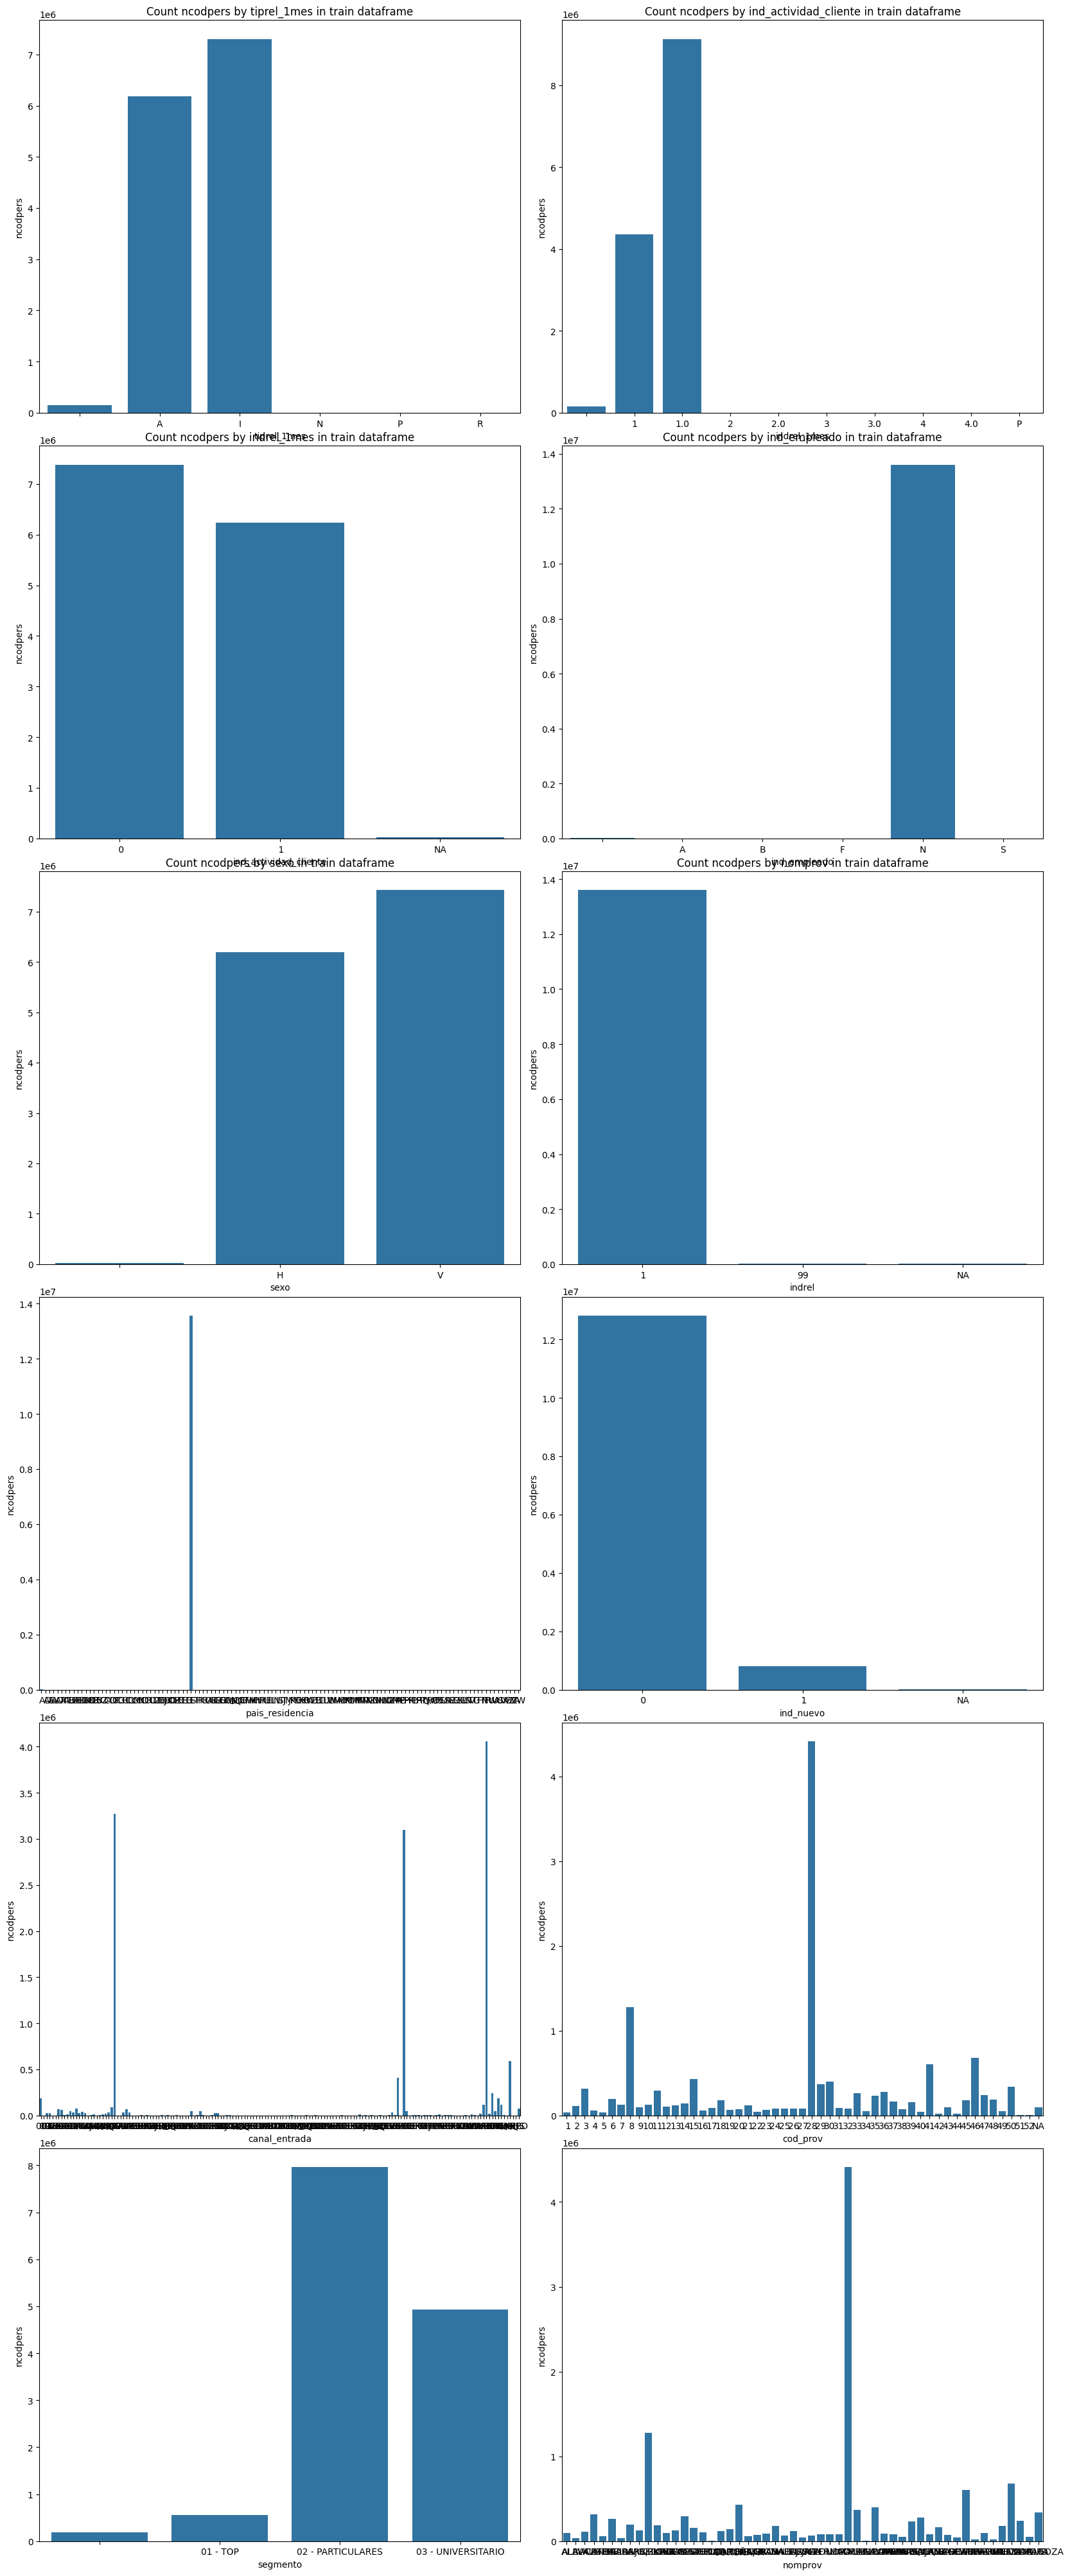

In [32]:
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(16.5, 40, forward=True)
fig.tight_layout(pad=1.6)

x = "tiprel_1mes"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "indrel_1mes"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "ind_actividad_cliente"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "ind_empleado"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "sexo"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[2, 0])
axs[2, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "indrel"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[2, 1])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "pais_residencia"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[3, 0])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "ind_nuevo"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[3, 1])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "canal_entrada"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[4, 0])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "cod_prov"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[4, 1])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "segmento"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[5, 0])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "nomprov"
y = "ncodpers"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(by=x).agg({y: "count"}).reset_index())
sns.barplot(data=agg_df, x=x, y=y, ax=axs[5, 1])
axs[2, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS, 'cat_features_1'))

### Исправление значений данных в категориальных переменных

In [33]:
df['indresi'].unique()

array(['S', '', 'N'], dtype=object)

In [34]:
df['indresi'] = df['indresi'].replace({'S': True, 'N':False})

In [35]:
df['conyuemp'].unique()

array(['', 'N', 'S'], dtype=object)

In [36]:
df['conyuemp'] = df['conyuemp'].replace({'S': True, 'N':False})

In [37]:
df['indrel_1mes'].unique()

array(['1.0', '1', '', '3.0', '3', '2', '2.0', '4.0', 'P', '4'],
      dtype=object)

In [38]:
df['indrel_1mes'] = df['indrel_1mes'].replace({'1.0': '1', '3.0':'3', '2.0':'2', '4.0':'4'})

In [39]:
df['indfall'].unique()

array(['N', '', 'S'], dtype=object)

In [40]:
df['indfall'] = df['indfall'].replace({'S': True, 'N':False})

In [41]:
df['ind_actividad_cliente'].unique()

array([' 1', ' 0', 'NA'], dtype=object)

In [42]:
df['ind_actividad_cliente'] = df['ind_actividad_cliente'].replace({' 1': True, ' 0':False})

In [43]:
df['ind_nuevo'].unique()

array([' 0', 'NA', ' 1'], dtype=object)

In [44]:
df['ind_nuevo'] = df['ind_nuevo'].replace({' 1': True, ' 0':False})

In [45]:
df['ind_empleado'].unique()

array(['N', '', 'A', 'B', 'F', 'S'], dtype=object)

In [46]:
df['ind_nuevo'].unique()

array([False, 'NA', True], dtype=object)

In [47]:
df = df.replace(['', 'NA'], np.nan)

In [48]:
df.to_parquet('./data/df.parquet')

In [49]:
df = pd.read_parquet('./data/df.parquet')

### Исправление значений целевых пременных

In [50]:
df.loc[:, ['age', 'renta', 'cod_prov', 'antiguedad']
] = df[['age', 'renta', 'cod_prov', 'antiguedad']
].apply(pd.to_numeric, errors='coerce')

In [51]:
target_col = df.columns[24:49]

In [52]:
df.loc[:, target_col].apply(lambda x: x.unique())

ind_ahor_fin_ult1            [0, 1]
ind_aval_fin_ult1            [0, 1]
ind_cco_fin_ult1             [1, 0]
ind_cder_fin_ult1            [0, 1]
ind_cno_fin_ult1             [0, 1]
ind_ctju_fin_ult1            [0, 1]
ind_ctma_fin_ult1            [0, 1]
ind_ctop_fin_ult1            [0, 1]
ind_ctpp_fin_ult1            [0, 1]
ind_deco_fin_ult1            [0, 1]
ind_deme_fin_ult1            [0, 1]
ind_dela_fin_ult1            [0, 1]
ind_ecue_fin_ult1            [0, 1]
ind_fond_fin_ult1            [0, 1]
ind_hip_fin_ult1             [0, 1]
ind_plan_fin_ult1            [0, 1]
ind_pres_fin_ult1            [0, 1]
ind_reca_fin_ult1            [0, 1]
ind_tjcr_fin_ult1            [0, 1]
ind_valo_fin_ult1            [0, 1]
ind_viv_fin_ult1             [0, 1]
ind_nomina_ult1      [ 0,  1, None]
ind_nom_pens_ult1    [ 0,  1, None]
ind_recibo_ult1              [0, 1]
dtype: object

In [53]:
df = df[~df['ind_nomina_ult1'].isna()]

In [54]:
df = df[~df['ind_nom_pens_ult1'].isna()]

In [ ]:
# Найдем наиболее популярные продукты
df[df.columns[24:49]].mean().sort_values(ascending=False)

In [ ]:
df['ind_nomina_ult1'].unique()

In [ ]:
# Указание типов данных для столбцов
dtype_dict = {
    'fecha_dato': 'datetime64[ns]',
    'ncodpers': 'int',
    'ind_empleado': 'category',
    'pais_residencia': 'category',
    'sexo': 'category',
    'age': 'int',
    'fecha_alta': 'datetime64[ns]',
    'ind_nuevo': 'bool',
    'antiguedad': 'int',
    'indrel': 'str',
    'ult_fec_cli_1t': 'datetime64[ns]',
    'indrel_1mes': 'category',
    'tiprel_1mes': 'category',
    'indresi': 'bool',
    'indext': 'bool',
    'conyuemp': 'bool',
    'canal_entrada': 'category',
    'indfall': 'bool',
    'tipodom': 'category',
    'cod_prov': 'category',
    'nomprov': 'category',
    'ind_actividad_cliente': 'bool',
    'renta': 'float',
    'segmento': 'category',
    'ind_ahor_fin_ult1': 'bool',
    'ind_aval_fin_ult1': 'bool',
    'ind_cco_fin_ult1': 'bool',
    'ind_cder_fin_ult1': 'bool',
    'ind_cno_fin_ult1': 'bool',
    'ind_ctju_fin_ult1': 'bool',
    'ind_ctma_fin_ult1': 'bool',
    'ind_ctop_fin_ult1': 'bool',
    'ind_ctpp_fin_ult1': 'bool',
    'ind_deco_fin_ult1': 'bool',
    'ind_deme_fin_ult1': 'bool',
    'ind_dela_fin_ult1': 'bool',
    'ind_ecue_fin_ult1': 'bool',
    'ind_fond_fin_ult1': 'bool',
    'ind_hip_fin_ult1': 'bool',
    'ind_plan_fin_ult1': 'bool',
    'ind_pres_fin_ult1': 'bool',
    'ind_reca_fin_ult1': 'bool',
    'ind_tjcr_fin_ult1': 'bool',
    'ind_valo_fin_ult1': 'bool',
    'ind_viv_fin_ult1': 'bool',
    'ind_nomina_ult1': 'bool',
    'ind_nom_pens_ult1': 'bool',
    'ind_recibo_ult1': 'bool',
}

In [ ]:
# Проверим наличие дубликатов
df[df.columns[0:24]].duplicated().any()

In [ ]:
df.duplicated().mean()

In [ ]:
df[df['ind_empleado']=='P']

In [ ]:
df = df[~df['age'].isna()]

In [ ]:
df = df[~df['cod_prov'].isna()]

In [ ]:
df = df[~df['sexo'].isna()]

In [ ]:
df = df[~df['canal_entrada'].isna()]

In [ ]:
df = df[~df['segmento'].isna()]

In [ ]:
df['ind_hip_fin_ult1'].unique()

In [ ]:
df.sample()

In [ ]:
df_pivot = df.pivot_table(columns='sexo', index='ncodpers', values='age', aggfunc='median')
df_pivot

In [ ]:
df = df.astype(dtype_dict)

In [ ]:
df.info()

In [ ]:
df['sexo'].unique()

In [ ]:
df.describe()

In [ ]:
plt.hist(df[df['sexo']=='H']['age']
         , bins=10, alpha=0.5, label='Распределение мужчин')
plt.hist(df[df['sexo']=='V']['age']
         , bins=10, alpha=0.5, label='Распределение женщин')
plt.legend(loc='upper right')
plt.xlabel('Возраст', fontsize=12)
plt.title('Распредление возраста для пола клиентов', fontsize=14)
plt.savefig(os.path.join(ASSETS, 'age_by_sex_of_clients'))
plt.show()

In [ ]:
plt.hist(df[df['ind_empleado']=='A']['renta']
         , bins=20, alpha=0.5, label='Работающие')
plt.hist(df[df['ind_empleado']=='B']['renta']
         , bins=20, alpha=0.5, label='Раньше работал')
plt.hist(df[df['ind_empleado']=='F']['renta']
         , bins=20, alpha=0.5, label='Иждивенец')
plt.hist(df[df['ind_empleado']=='P']['renta']
         , bins=20, alpha=0.5, label='Пассивный (статус не определён)')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)
plt.title('Распредление доходов для формы занятости клиентов', fontsize=14)
plt.savefig(os.path.join(ASSETS, 'income_by_empl_clients'))
plt.show()

plt.hist(df[df['ind_empleado']=='N']['renta']
         , bins=20, alpha=0.5, label='Безработный')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)
plt.title('Распредление доходов для формы занятости клиентов', fontsize=14)
plt.show()


In [ ]:
numeric_col = ['age', 'antiguedad', 'renta']

In [ ]:
def outliers(data, num_cols):
    for column in num_cols:
        boxplot = plt.boxplot(df[column].values)
        plt.title("Диаграмма размаха для " + column)
        plt.savefig(os.path.join(ASSETS, 'boxplot' + column))
        plt.show()
        outliers = list(boxplot["fliers"][0].get_data()[1])
        outlier = df[df[column].isin(outliers)]
        print("Количество аномалий: ", len(outlier))

In [ ]:
outliers(df, numeric_col)

In [ ]:
df.boxplot(column = 'renta')

In [ ]:
def outliers_filter(data, num_cols, threshold):
    '''Функция выделяет индексы объектов с выбросами
    по заданным признакам и threshold'''
    potential_outliers = pd.DataFrame()
    for col in num_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3-Q1
        margin = threshold*IQR
        lower = Q1 - margin
        upper = Q3 + margin 
        potential_outliers[col] = ~data[col].between(lower, upper)
        outliers = potential_outliers.any(axis=1)        
    return outliers

In [ ]:
df = df[~outliers_filter(df, numeric_col, 1.5)]

In [ ]:
outliers(df, numeric_col)

In [ ]:
df[df['renta'].isna()]

In [ ]:
df['ncodpers'].nunique()

In [ ]:
df

In [ ]:
df['ind_empleado'].unique()

In [ ]:
plt.hist(df[df['ind_empleado']=='A']['renta']
         , bins=20, alpha=0.5, label='Работающие')
plt.hist(df[df['ind_empleado']=='B']['renta']
         , bins=20, alpha=0.5, label='Раньше работал')
plt.hist(df[df['ind_empleado']=='F']['renta']
         , bins=20, alpha=0.5, label='Иждивенец')
plt.hist(df[df['ind_empleado']=='P']['renta']
         , bins=20, alpha=0.5, label='Пассивный (статус не определён)')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)
plt.title('Распредление дохода для различных типов клиента', fontsize=14)
plt.savefig(os.path.join(ASSETS, 'income_by_client_type'))
plt.show()

plt.hist(df[df['ind_empleado']=='N']['renta']
         , bins=20, alpha=0.5, label='Безработный')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)

In [ ]:
df[df['segmento']=='01 - TOP']['renta'].hist(bins=100, alpha=0.5, label='VIP')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)
plt.title('Распредление дохода для VIP', fontsize=14)
plt.savefig(os.path.join(ASSETS, 'income_by_vip_clients'))
plt.show()

In [ ]:
df[df['segmento']=='03 - UNIVERSITARIO']['renta'].hist(
    bins=100, alpha=0.5, label='Выпускники колледжей')
df[df['segmento']=='02 - PARTICULARES']['renta'].hist(
    bins=100, alpha=0.5, label='Обыкновенные')
plt.legend(loc='upper right')
plt.xlabel('Доход', fontsize=12)
plt.title('Распредление дохода для выпускников колледжа и обычных клиентов', fontsize=14)
plt.savefig(os.path.join(ASSETS, 'income_by_colledge_client'))
plt.show()

In [ ]:
df['canal_entrada'].unique()

In [ ]:
df['segmento'].unique()

In [ ]:
df['ind_actividad_cliente'].mean()

In [ ]:
df[df['ind_nuevo']]['fecha_alta'].hist(bins=100, alpha=0.5)
df[~df['ind_nuevo']]['fecha_alta'].hist(bins=100, alpha=0.5)

In [ ]:
RUN_NAME = "eda"

In [ ]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id.experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS)

In [ ]:
# Оценим количество продуктов банка
df[df.columns[24:49]].mean().sort_values(ascending=False)

In [ ]:
new_clients = df[df['ind_nuevo']==True]

In [ ]:
new_clients

In [ ]:
target_col

In [ ]:
data = df[df['ind_actividad_cliente']].copy()

In [ ]:
data

In [ ]:
data['ind_nuevo'].mean()

In [ ]:
df['fecha_dato'].describe

# Преобразование и разбиение данных

In [ ]:
df['fecha_dato'].unique()

In [ ]:
events = df.rename(columns={'ncodpers': 'user_id'}).copy()

In [ ]:
events.replace(np.nan, 'NaN', inplace=True)

In [ ]:
def train_test_split(data, train_test_global_time_split_date):
    
    train_test_global_time_split_idx = df["fecha_dato"]==train_test_global_time_split_date
    events_train = data[train_test_global_time_split_idx]
    events_test = data[~train_test_global_time_split_idx]
    
    # количество пользователей в train и test
    users_train = events_train["user_id"].drop_duplicates()
    users_test = events_test["user_id"].drop_duplicates()
    # количество пользователей, которые есть и в train, и в test
    common_users = set(users_test).intersection(set(users_train))
    
    print(len(users_train), len(users_test), len(common_users))
    return events_train, events_test, users_train, users_test, common_users

In [ ]:
events_train, events_test, users_train, users_test, common_users = train_test_split(
    events, '2015-05-28 00:00:00'
)

In [ ]:
# Количество ячеек в матрице
all_cells = events_train['user_id'].nunique()*len(df.columns[24:49])
all_cells

In [ ]:
# Степень разреженности матрицы
(all_cells-len(events_train))/all_cells

In [ ]:
# Кодирование user_id
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
# Преобразование user_id в числовые значения
user_id_train = user_encoder.transform(events_train['user_id'])
user_id_test = user_encoder.transform(events_test['user_id'])
# Чтобы убрать предупреждение используем .loc для сохранения значений
events_train.loc[:, 'user_id_enc'] = user_id_train
events_test.loc[:, 'user_id_enc'] = user_id_test

In [ ]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(target_col)
target_col_enc = item_encoder.transform(target_col)
# Переименование столбцов
events_train = events_train.rename(columns=dict(zip(target_col, target_col_enc)))
events_train = events_test.rename(columns=dict(zip(target_col, target_col_enc)))

In [ ]:
with open('../models/user_encoder.pkl', 'wb') as file:
    pickle.dump(user_encoder, file)
with open('../models/item_encoder.pkl', 'wb') as file:
    pickle.dump(item_encoder, file)

In [ ]:
events_train = events_train[events_train.columns[24:49]].groupby(by='user_id_enc').mean()
events_train

In [ ]:
events_train.stack().reset_index()

In [ ]:
events_train = events_train.stack().reset_index()
events_train.columns = ["user_id_enc", "item_id_enc", "score"]
events_train = events_train[events_train["score"]>0]
events_train

In [ ]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["score"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)
user_item_matrix_train.data

In [ ]:
sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3 

In [ ]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендции для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [ ]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=RANDOM_STATE)
als_model.fit(user_item_matrix_train) 

In [ ]:
user_ids_encoded = range(len(events_train['user_id_enc'].unique()))
user_ids_encoded

In [ ]:
user_item_matrix_train

In [ ]:
user_item_matrix_train[user_ids_encoded]

In [ ]:
get_recommendations_als(user_item_matrix_train, als_model, 1050617, user_encoder, item_encoder, False, 5)

In [ ]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=True, N=5)

In [ ]:
als_model.save('../models/als_model')

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
als_recommendations = als_recommendations.sort_values('score', ascending=False)
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("../data/als_recommendations.parquet")

In [ ]:
als_recommendations.pivot_table(index='user_id', columns = 'item_id')

In [ ]:
als_recommendations[als_recommendations['user_id']==179350]

In [ ]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 5, то NDCG - не определена
    if len(rating) < 5:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

In [ ]:
events_test

In [ ]:
test_matrix = events_test[target_col.insert(0, 'user_id')].groupby(by='user_id').mean()

In [ ]:
events_test = test_matrix.stack().reset_index()
events_test.columns = ["user_id", "item_id", "rating_test"]
events_test = events_test[events_test['rating_test']>0]
events_test

In [ ]:
als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "item_id", "rating_test"]],
           on=["user_id", "item_id"], how="left")
)

In [ ]:
als_recommendations

In [ ]:
rating_test_idx = ~als_recommendations["rating_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5))

In [ ]:
rating_test_idx

In [ ]:
len(ndcg_at_5_scores)/len(events['user_id'].unique())

In [ ]:
#als_model = AlternatingLeastSquares().load('../models/als_model.npz')

In [ ]:
events_train

In [ ]:
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
events_train["user_id"] = user_encoder.inverse_transform(events_train["user_id_enc"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])
events_train["item_id"] = item_encoder.inverse_transform(events_train["item_id_enc"])

In [ ]:
events_train

In [ ]:
events_test

In [ ]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 10

In [ ]:
train_item_ids_enc

In [ ]:
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

In [ ]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

In [ ]:
similar_items_score = pd.DataFrame(sim_item_scores.tolist())


In [ ]:
similar_items = pd.DataFrame(sim_item_item_ids_enc.tolist())

In [ ]:
similar_items

In [ ]:
similar_items = similar_items.loc[:, :1]
similar_items.columns = ["item_id_enc", 'item_id_2']
similar_items['score'] = similar_items_score.loc[:, 1]
similar_items = similar_items.query("item_id_enc != item_id_2") 
similar_items['item_id_1'] = item_encoder.inverse_transform(similar_items['item_id_enc'])
similar_items['item_id_2'] = item_encoder.inverse_transform(similar_items['item_id_2'])
similar_items

In [ ]:
events_train

In [ ]:
content_recommendations = events_train.loc[:, ('user_id', 'item_id')]

In [ ]:
content_recommendations = pd.merge(content_recommendations[['user_id', 'item_id']],
        similar_items[['item_id_1', 'item_id_2', 'score']].rename(columns={"item_id_1": "item_id"}),
        on='item_id',
        how = 'inner')

In [ ]:
content_recommendations = content_recommendations.drop('item_id', axis=1).rename(columns={"item_id_2": "item_id"})

In [ ]:
content_recommendations

In [ ]:
content_recommendations.to_parquet('../data/content_recommendations.parquet')

# Ранжирование рекомендаций

In [ ]:
len(events[events['ind_actividad_cliente']]['user_id'].unique())

In [ ]:
new_users = events[events['ind_actividad_cliente']]['user_id'].unique()

In [ ]:
users_test.isin(events[events['ind_actividad_cliente']]['user_id'].unique())

In [ ]:
events_test

In [ ]:
# задаём точку разбиения
split_for_labels_idx = events_test["user_id"].isin(new_users)
events_labels = events_test[split_for_labels_idx].copy()
events_test_2 = events_test[~split_for_labels_idx].copy() 

In [ ]:
candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=('user_id', 'item_id'),
    how="outer")

len(candidates)

In [ ]:
candidates

In [ ]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]],
                              on=('user_id', 'item_id'),
                              how="left")

In [ ]:
candidates["target"] = candidates["target"].fillna(0).astype("int")
candidates

In [ ]:
candidates.target.mean()

In [ ]:
candidates.to_parquet('../data/candidates.parquet')

In [ ]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [ ]:
candidates_to_sample.target.mean()

In [ ]:
candidates_to_sample

In [ ]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 3
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=RANDOM_STATE, replace=True))
])

In [ ]:
candidates_for_train['target'].mean()

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score']
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

In [ ]:
cb_model.save_model('../models/catboost_model.bin')

In [ ]:
candidates_for_train.reset_index(drop=True).to_parquet('../data/candidates_for_train.parquet')

In [ ]:
candidates_to_rank = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=('user_id', 'item_id'),
    how="outer")

In [ ]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
print(len(candidates_to_rank))

In [ ]:
candidates_to_rank.reset_index(drop=True).to_parquet('./data/candidates_to_rank.parquet')

### Ранжирование кандидатов для рекомендаций без доп признаков

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score']
target = 'target'

In [ ]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

In [ ]:
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [ ]:
candidates_to_rank

In [ ]:
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["cb_score"].rank(method='first', ascending=False)

In [ ]:
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank[candidates_to_rank['rank']<=max_recommendations_per_user]

In [ ]:
final_recommendations

In [ ]:
final_recommendations.reset_index(drop=True).to_parquet('../data/recommendations.parquet')

In [ ]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common 

In [ ]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [ ]:
# количество холодных пользователей
cold_users = set(users_test).difference(set(users_train))
print(len(cold_users)) 

In [ ]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=24)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

In [ ]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])

print(feature_importance )

In [ ]:
final_recommendations[final_recommendations['user_id']==15933]

### Обучение модели с доп признаками по пользователям

In [ ]:
events[events.columns[:24]].columns

In [ ]:
def get_user_features(events):
    """ считает пользовательские признаки """
    user_features = events.groupby("user_id").agg(
        client_experience=("antiguedad", "max"),
        age=("age", "max"),
        income=("renta", "mean"),
        sex=("sexo", "last"),
        status=("ind_empleado", "first"),
        citizenship=("pais_residencia", "first"),
        first_client=("indrel", "first"),
        client_group=("indrel_1mes", "first"),
        client_type=("tiprel_1mes", "first"),
        resident=("indresi", "first"),
        born_in_esp=("indext", "first"),
        affiliated=("conyuemp", "first"),
        channel=("canal_entrada", "last"),
        deceased_index=("indfall", "first"),
        address_type=("tipodom", "first"),
        code_prov=("cod_prov", "first"),
        name_prov=("nomprov", "first"),
        is_active=("ind_actividad_cliente", "first"),
        client_cat=("segmento", "first")      
    )
    
    return user_features.reset_index()

In [ ]:
events_labels

In [ ]:
get_user_features(events)

In [ ]:
user_features_for_train = get_user_features(events)

In [ ]:
user_features_for_train[user_features_for_train['channel'].isna()]

In [ ]:
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")
candidates_for_train

In [ ]:
events_inference = pd.concat([events_train, events_labels])

In [ ]:
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

In [ ]:
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

user_features_for_ranking = get_user_features(events)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left")

In [ ]:
candidates_to_rank

In [ ]:
candidates_for_train['target'].mean()

In [ ]:
candidates_for_train.columns

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score', 'client_experience',
            'age', 'income', 'sex', 'status', 'citizenship',
            'first_client', 'client_group', 'client_type', 'resident',
            'born_in_esp', 'affiliated', 'channel', 'deceased_index',
            'address_type', 'name_prov', 'is_active', 'client_cat']
cat_features = ['sex', 'status', 'citizenship','first_client',
                'client_group', 'client_type', 'resident',
                'born_in_esp', 'affiliated', 'channel', 'deceased_index',
                'address_type', 'name_prov', 'is_active', 'client_cat']
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target],
    cat_features=cat_features
)

# инициализируем модель CatBoostClassifier
cb_model_u = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model_u.fit(train_data)

In [ ]:
cb_model_u.save_model('../models/catboost_model_u.bin')

In [ ]:
candidates_for_train.reset_index(drop=True).to_parquet('../data/candidates_for_train_u.parquet')

In [ ]:
candidates_to_rank.reset_index(drop=True).to_parquet('../data/candidates_to_rank_u.parquet')

In [ ]:
candidates_to_rank

### Ранжирование кандидатов для рекомендаций с доп признаками по пользователям

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score', 'client_experience',
            'age', 'income', 'sex', 'status', 'citizenship',
            'first_client', 'client_group', 'client_type', 'resident',
            'born_in_esp', 'affiliated', 'channel', 'deceased_index',
            'address_type', 'name_prov', 'is_active', 'client_cat']
cat_features = ['sex', 'status', 'citizenship','first_client',
                'client_group', 'client_type', 'resident',
                'born_in_esp', 'affiliated', 'channel', 'deceased_index',
                'address_type', 'name_prov', 'is_active', 'client_cat']
target = 'target'

# Create the Pool object
inference_data = Pool(
    data=candidates_to_rank[features],
    cat_features=cat_features
)

In [ ]:
predictions = cb_model_u.predict_proba(inference_data)

In [ ]:
candidates_to_rank["cb_score"] = predictions[:, 1]

In [ ]:
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [ ]:
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["cb_score"].rank(method='first', ascending=False)

In [ ]:
max_recommendations_per_user = 24
final_recommendations = candidates_to_rank[candidates_to_rank['rank']<=max_recommendations_per_user]

In [ ]:
final_recommendations.reset_index(drop=True).to_parquet('../data/recommendations_u.parquet')

In [ ]:
final_recommendations

### Оценка качества рекомендаций без дополнительных признаков

In [ ]:
metrics = {}

In [ ]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)
metrics["precision"] = cb_precision_5
metrics["recall"] = cb_recall_5
print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

#### Покрытие (англ. coverage)

In [ ]:
# расчёт покрытия по объектам
users_covered = len(final_recommendations['user_id'].drop_duplicates())
users_total = len(events['user_id'].drop_duplicates())
cov_items = users_covered / users_total
metrics["coverage"] = cov_items
print(f"coverage: {cov_items:.2f}") 

In [ ]:
events_inference.loc[:, "listened"] = True

In [ ]:
final_recommendations = final_recommendations.merge(
    events_inference[["user_id", "item_id", "listened"]], 
    on=["user_id", "item_id"],
    how="left"
)

In [ ]:
final_recommendations["listened"] = final_recommendations["listened"].fillna(False).astype("bool")

In [ ]:
novelty_5 = (1-final_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean())

In [ ]:
metrics["novelty"] = novelty_5.mean()
print(f"novelty: {novelty_5.mean():.2f}") 

In [ ]:
feature_importance = pd.DataFrame(cb_model_u.get_feature_importance(), 
    index=features, 
    columns=["fi"])

print(feature_importance.sort_values(by='fi', ascending=False))

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment_id:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [ ]:
pip_requirements = '../requirements.txt'
#signature = mlflow.models.infer_signature(candidates_to_rank[features], predictions)
input_example = candidates_to_rank[features][:10]
metadata = {'model_type': 'als_cnt_features'}

In [ ]:
metrics

In [ ]:
RUN_NAME="Bank_recsys"

In [ ]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id.experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("../models/als_model.pkl", "../models/item_encoder.pkl", "../models/user_encoder.pkl")
    model_info = mlflow.catboost.log_model(
        cb_model=catboos_model_u,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        metadata=metadata,
        #signature=signature,
        input_example=input_example
        
    )